In [1]:
import json

import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


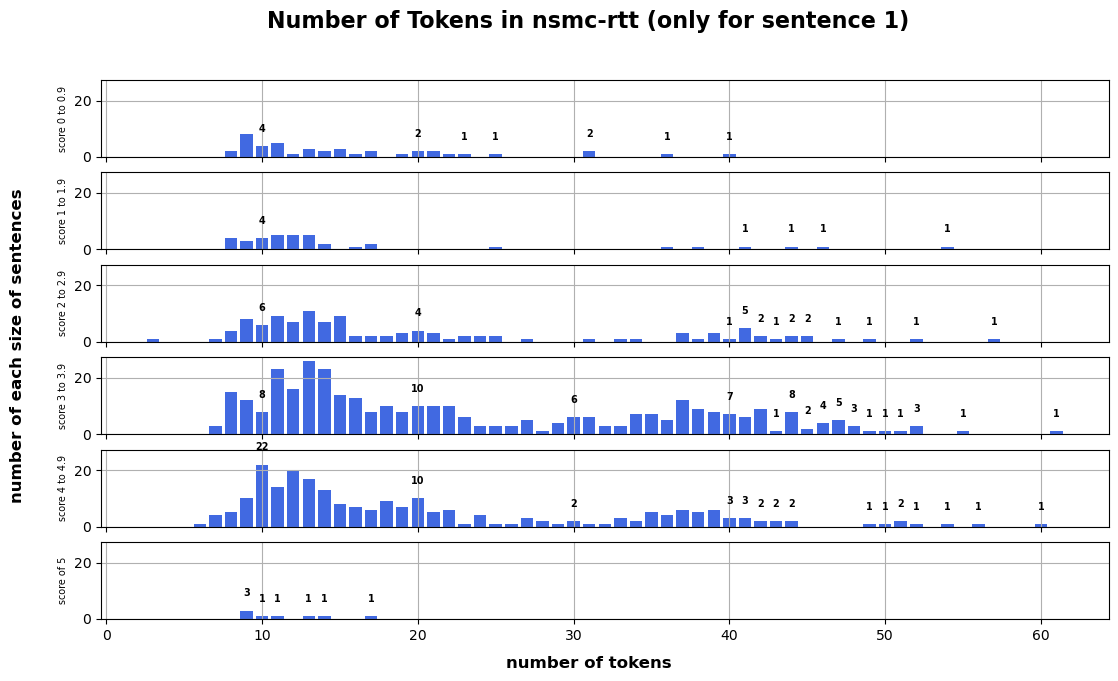

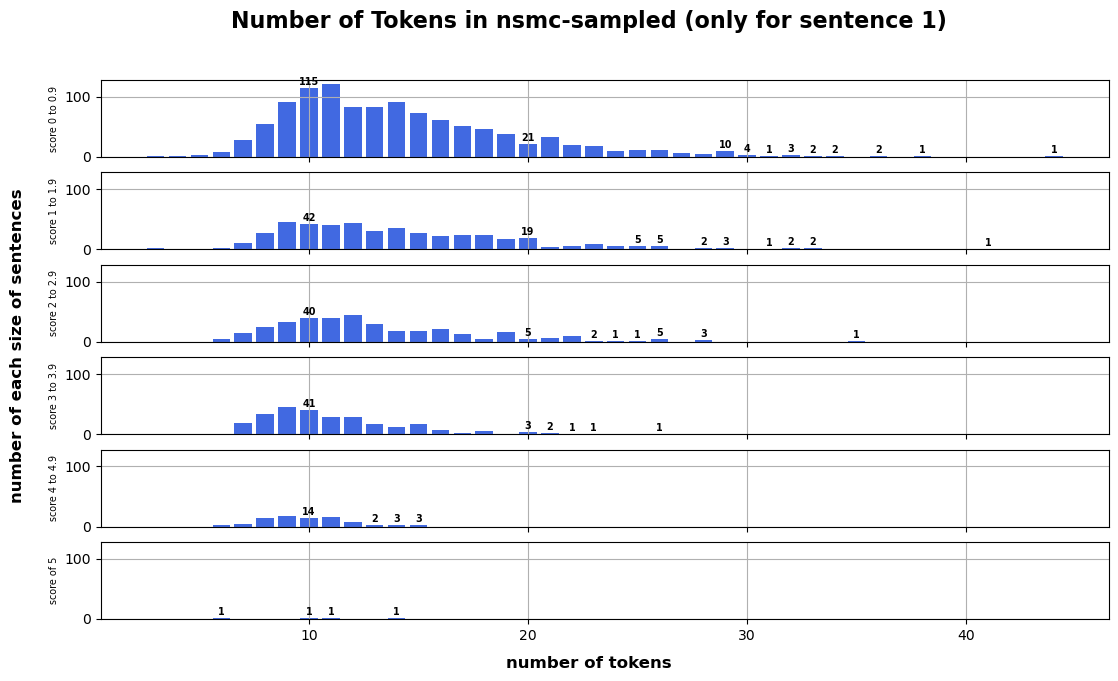

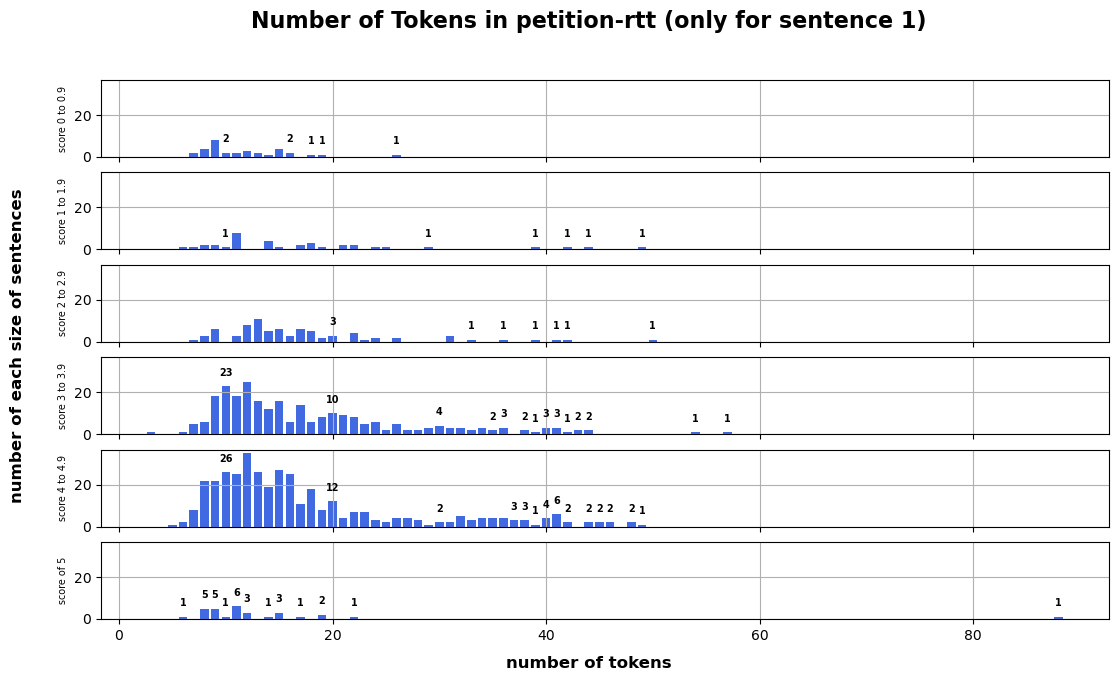

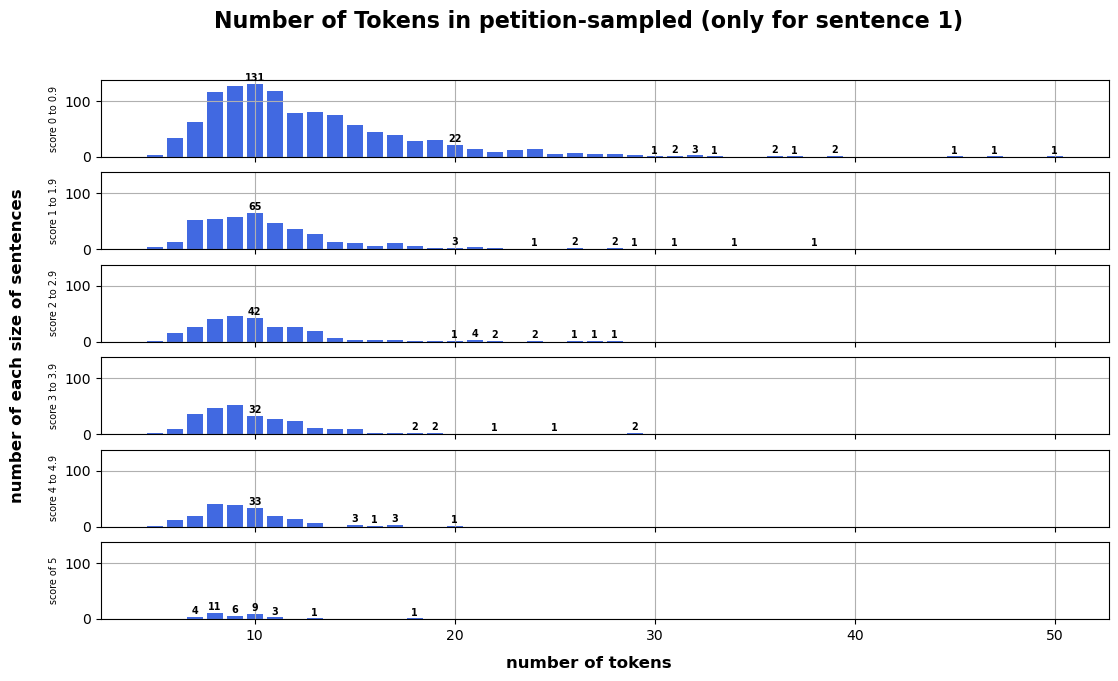

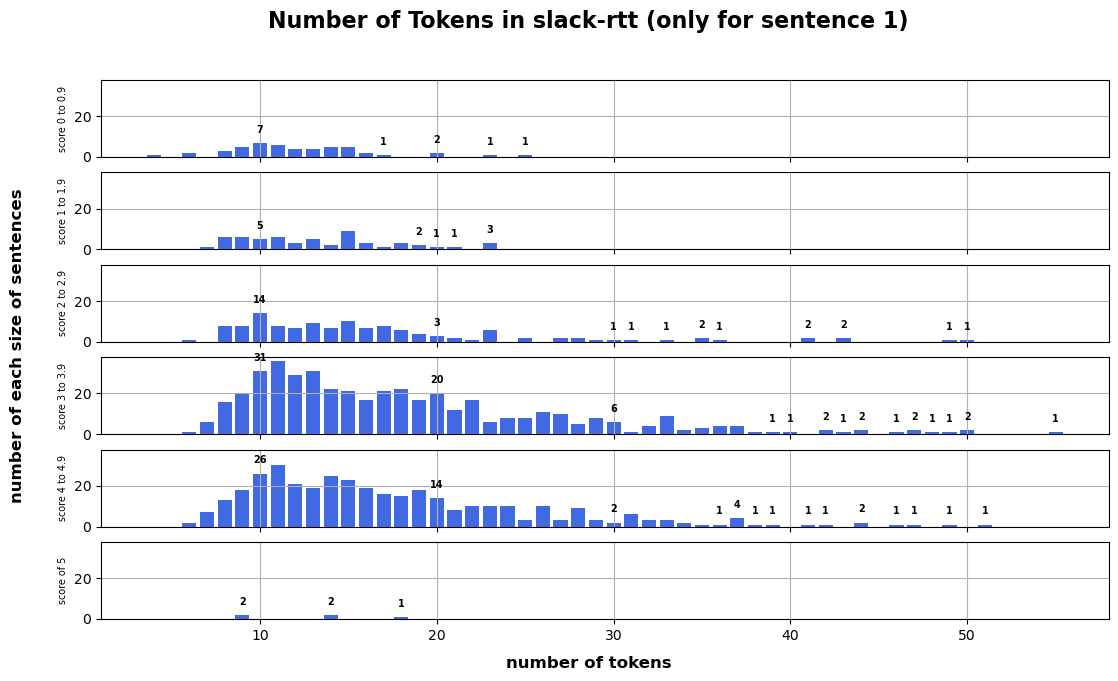

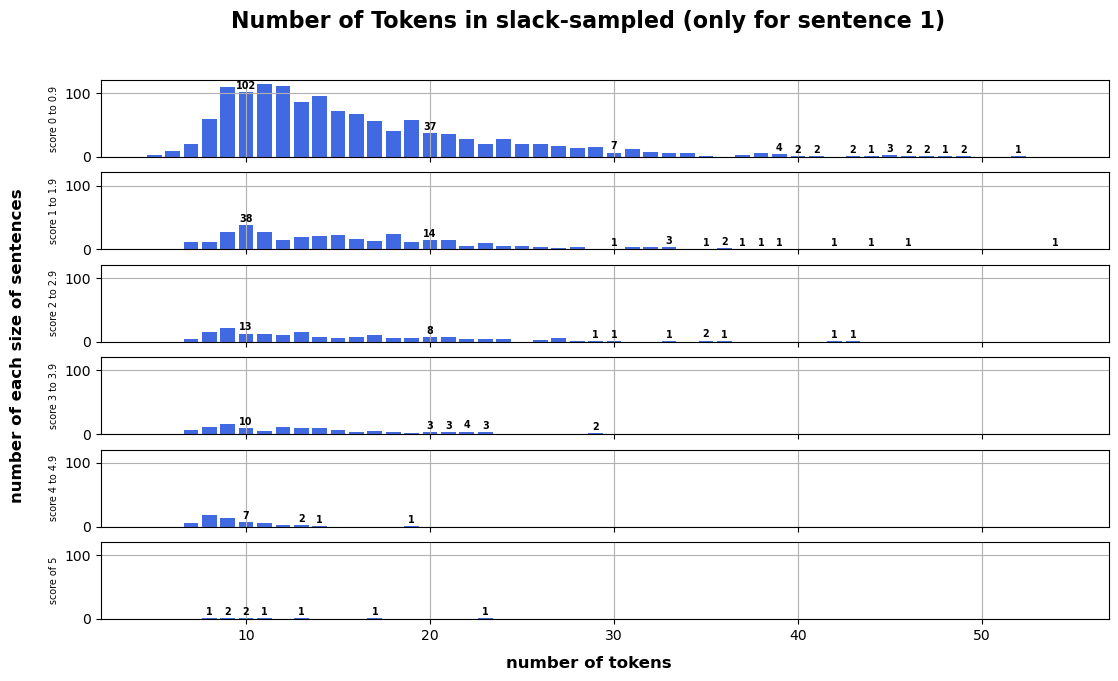

In [2]:
## source, score별로 나누어서 토큰 개수 확인해보기 

# settings
from collections import Counter, OrderedDict

train_path = './data/train.csv'
dev_path = './data/dev.csv'

train_data = pd.read_csv(train_path)
dev_data = pd.read_csv(dev_path)

tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')

# Function Settings
def get_num_tokens(df):
    sentence1_len, sentence2_len = [], []
    sentence1_unk, sentence2_unk = [], []
    
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']

        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    return sentence1_len, sentence2_len, sentence1_unk, sentence2_unk
    # return pd.DataFrame({'number of tokens':sentence1_len, 'label score':df.label.values.tolist()})


# 1. 전체 df에 대해 score 5단계로 분류, 열 추가
train_data_scored = train_data.copy(deep=True)
score_integer = []

for i, item in train_data_scored.iterrows():
    label_value = int(item['label'])
    if   label_value == 0:  col = 0
    elif label_value < 2.0: col = 1
    elif label_value < 3.0: col = 2
    elif label_value < 4.0: col = 3
    elif label_value < 5.0: col = 4
    else:                   col = 5
        
    score_integer.append(col)
train_data_scored['score_class'] = score_integer

# 2. sentence 별 토큰 개수 넣기
s1_len, s2_len, s1_unk, s2_unk = get_num_tokens(train_data_scored)

train_data_scored['s1_num_tokens'] = s1_len
train_data_scored['s2_num_tokens'] = s2_len
train_data_scored['s1_num_unk'] = s1_unk
train_data_scored['s2_num_unk'] = s2_unk


source_list = sorted(train_data['source'].unique())

for source_name in source_list:
    # 3. source 별로 그룹화 - test for nsmc
    grouped_df = train_data_scored.groupby(['source'])
    grouped_df = grouped_df.get_group(source_name).groupby(['score_class'])

    # score 0~5
    score_list_unique = sorted(list(set(score_integer)))

    # 3-1. axis setting. x=토큰개수, y=해당 개수
    x_axis, y_axis = [], []
    fig, axes = plt.subplots(6, 1, 
                             figsize=(13, 7), 
                             sharey=True, 
                             sharex=True
                             )
    
    # max y variable
    # _max_y_value = -1

    # 3-1. score 0~5 별로 그룹핑
    for score in score_list_unique:
        s1_x, s1_y, s2_x, s2_y = [], [], [], []
        u1_x, u1_y, u2_x, u2_y = [], [], [], []
        grouped_df_scored = grouped_df.get_group(score).copy(deep=True)
        
        # token numbers
        s1_counted   = OrderedDict(Counter(sorted(grouped_df_scored['s1_num_tokens'].values.tolist())))
        s2_counted   = OrderedDict(Counter(sorted(grouped_df_scored['s2_num_tokens'].values.tolist())))
        # unk token numbers
        unk1_locations = grouped_df_scored[grouped_df_scored['s1_num_unk'] > 0]
        unk1_counted = OrderedDict(Counter(sorted(grouped_df_scored['s1_num_unk'].values.tolist())))
        unk2_counted = OrderedDict(Counter(sorted(grouped_df_scored['s2_num_unk'].values.tolist())))
        
        s1_x, s1_y = s1_counted.keys(),   s1_counted.values()
        s2_x, s2_y = s2_counted.keys(),   s2_counted.values()
        u1_x, u1_y = list(unk1_counted.keys())[1:], list(unk1_counted.values())[1:]
        u2_x, u2_y = list(unk2_counted.keys())[1:], list(unk2_counted.values())[1:]
        
        axes[score].bar(s1_x, s1_y, color='royalblue')
        axes[score].grid(zorder=0)
        #axes[score].bar(u1_x, u1_y, bottom=list(s1_y)[:len(u1_x)], color='tomato')
        #print(f"unk value: {score}, x: {u1_x}, y: {u1_y}")

        upper_20_value = pd.Series(s1_x).quantile(0.75)
        for idx, value in zip(s1_x, s1_y):
            if idx % 10 != 0 and score != 5 and idx < upper_20_value:
                continue
            
            axes[score].text(idx, value+5, s=value, ha='center', fontsize='x-small', fontweight='bold')
            if score != 5:
                axes[score].set_ylabel(f'score {score} to {float(score)+0.9}', fontsize='x-small')
            else:
                axes[score].set_ylabel(f'score of {score}', fontsize='x-small')
        #axes[score].set_ylim(0, 150)
    
    fig.suptitle(f"Number of Tokens in {source_name} (only for sentence 1)", fontsize=16, fontweight='bold')
    #axes.set_xlabel('number of tokens', fontsize=12)
    #axes.set_ylabel('number of each size of sentences', fontsize=12)
    
    
    fig.text(0.5, 0.04, 'number of tokens', ha='center', fontsize=12, fontweight='bold')
    fig.text(0.055, 0.5, 'number of each size of sentences', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    #axes[5].set_ylim(0, 5)
    plt.show()